In [1]:
import sys; sys.path.insert(0, '../')
import os
from scipy import io
from pde_diff import *
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_PATH = '../experimental_data/NLS.mat'
data = io.loadmat(DATA_PATH)

t = data['tt'].flatten()[:,None]; dt = t[1]-t[0]; nt = len(t)
x = data['x'].flatten()[:,None]; dx = x[1]-x[0]; nx = len(x)

u = data['uu'].T
X, T = np.meshgrid(x,t)

dt = t[1]-t[0]
dx = x[2]-x[1]
n = len(x)
m = len(t)

<ipython-input-3-ad6f84c80515>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0, 't')

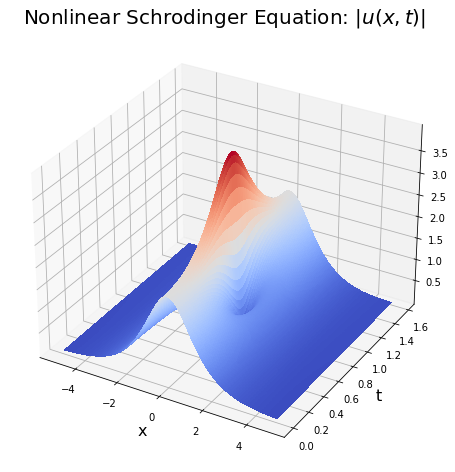

In [3]:
fig = figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, T, abs(u), rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title(r'Nonlinear Schrodinger Equation: $|u(x,t)|$', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

In [4]:
ut = np.zeros((m,n), dtype=np.complex64)
ux = np.zeros((m,n), dtype=np.complex64)
uxx = np.zeros((m,n), dtype=np.complex64)
uxxx = np.zeros((m,n), dtype=np.complex64)

for i in range(n):
    ut[:,i] = FiniteDiff(u[:,i], dt, 1)
for i in range(m):
    ux[i,:] = FiniteDiff(u[i,:], dx, 1)
    uxx[i,:] = FiniteDiff(u[i,:], dx, 2)
    uxxx[i,:] = FiniteDiff(u[i,:], dx, 3)
    
ut = np.reshape(ut, (n*m,1), order='F')
ux = np.reshape(ux, (n*m,1), order='F')
uxx = np.reshape(uxx, (n*m,1), order='F')
uxxx = np.reshape(uxxx, (n*m,1), order='F')
X_ders = np.hstack([np.ones((n*m,1)),ux,uxx,uxxx])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F'), np.reshape(abs(u), (n*m,1), order='F')])
derivatives_description = ['','u_{x}','u_{xx}', 'u_{xxx}']

X, rhs_des = build_Theta(X_data, X_ders, derivatives_description, 3, data_description = ['u','|u|'])

In [5]:
u.shape

(201, 256)

In [6]:
# Solve with STRidge
w = TrainSTRidge(X,ut,10**-5,500)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.000001 +0.503178i)u_{xx}
    + (-0.000001 +1.000581i)u|u|^2
   


In [7]:
err = np.abs(np.array([200*(0.503178-0.5), 100*(1.000581-1)]))
err.mean(), err.std()

(0.34684999999999855, 0.2887500000000043)

In [8]:
# Not working ???
Z, E1 = RobustPCA(u, lam_2 = 0.3)
Ut, R, rhs_des = build_linear_system(Z, dt, dx, D=3, P=3, time_diff='FD', space_diff='FD')

# Solve noiseless data with RPCA + STR
w = TrainSTRidge(R, Ut, 10**-5, 500)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

# Solve noiseless data with RPCA+LRSTR
Ut1 = np.reshape(Ut, (nx, nt))
w, X, E2 = Robust_LRSTR(R, Ut1, rhs_des, lam_1 = 1e-5, lam_3 = 0.3, lam_4 = 1e-4, d_tol = 500)
print("PDE derived using RPCA+LRSTR for clear data U")
print_pde(w, rhs_des)

Please ensure that the shape of U is correct.
iteration:1, err:2290.531350224413, nc_norm:518.245133761525 eta1:0.006777342290238597
iteration:50, err:0.02437402318555792, nc_norm:593.605570407962 eta1:0.7232709015533997
iteration:100, err:0.00025193319821954275, nc_norm:290.51775543043885 eta1:84.90538799642006
iteration:145, err:9.43495124465672e-06, nc_norm:287.9495569289277 eta1:6188.794798530424
PDE derived using STRidge
u_t = (0.000000 -0.000000i)u^3
    + (0.000000 -0.000000i)u^2u_{xx}
   
iteration:1, err:17299.885708923037, nc_norm:3796.5556406893775 eta2:0.0009791142219448276
u_t = 
u_t = (0.000003 -0.000019i)u^3
    + (0.000025 +0.000000i)u^2u_{x}
   
u_t = (0.000003 +0.000007i)u^3
   
u_t = (0.000003 +0.000006i)u^3
   
u_t = (0.000003 +0.000005i)u^3
   
u_t = (0.000003 +0.000004i)u^3
   
u_t = (0.000003 +0.000004i)u^3
   
u_t = (0.000002 +0.000003i)u^3
   
u_t = (0.000005 -0.000011i)u^3
    + (0.000012 +0.000002i)u^2u_{x}
   
u_t = (0.000004 -0.000009i)u^3
    + (0.000010 +

KeyboardInterrupt: 